# Gamma Strategies Simulator

This notebook is an example of the usage of the ```StrategyImplementer.py``` to simulate the performance of Uniswap v3 strategies.

This notebook allows the analysis of any strategy for the Hypervisor on the **USDC-WETH** pool contract ```0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8```. By modifying the ```StrategyImplementer.py``` contract you can easily implement any strategy and analyze the performance using the output of this notebook.

The workflow is as follows:

1. Using ```GetPoolData.py``` we download all swaps in the pool, as well as price history data from Bitquery. From FlipsideCrypto we download the amount of virtual liquidity in the pool at every block. These are processed into ```swap_data``` pandas DataFrame, which has every swap in the pool and the virtual liquidity in the pool the block prior to the swap. Additionally, ```price_data``` has historical price data from Uniswap. 
2. We generate from the historical price data estimates of future returns through the empirical cumulative density function, which provides a probability distribution over price changes, where these changes are calculated over time periods of ```AGGREGATED_MINUTES``` length. 
3. We simulate the strategy and provide an estimate of the fees that would have been accrued given the swaps that were in the price range of the strategy at each point in time, by using the proportion of liquidity provided relative to the pool's liquidity from the FlipsideCrypto data.
4. The ```data_strategy``` DataFrame summarizes the results of the strategy.

To run this notebook locally:

1. Generate an API key from [Bitquery](https://graphql.bitquery.io/ide) and save it in a file ```config.py``` in this directory.
2. Run this notebook.

## Download data

In [1]:
import pandas as pd
import numpy as np
import GetPoolData
import StrategyImplementer
import itertools
from statsmodels.distributions.empirical_distribution import ECDF, monotone_fn_inverter

# Create config.py in this directory and enter your own Bitquery API Token
from config import BITQUERY_API_TOKEN

#################
#
# Download data
#
################

# Get Swap Data
DOWNLOAD_DATA      = False
address            = '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8'
token_0_address    = '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48'
token_1_address    = '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2'

# Price data for theThese must be month ends
price_data_begin         = '2020-12-31'
price_data_end           = '2021-12-31'

swap_data  = GetPoolData.get_pool_data_flipside(address,BITQUERY_API_TOKEN,DOWNLOAD_DATA)  
price_data = GetPoolData.get_price_data_bitquery(token_0_address,token_1_address,price_data_begin,price_data_end,BITQUERY_API_TOKEN,DOWNLOAD_DATA)

# Use empirical CDF for extracting boundaries of strategy
price_data['price'] = price_data['close_price']
price_data_filtered = StrategyImplementer.aggregate_price_data(price_data,AGGREGATED_MINUTES)
ecdf                = ECDF(price_data_filtered['price_return'].to_numpy())
ecdf_inv            = monotone_fn_inverter(ecdf,np.linspace(price_data_filtered['price_return'].min(),price_data_filtered['price_return'].max(),1000),vectorized=False)



# Simulate Strategies

Setting up, assume we will place a 50/50 \\$100k USDC + the equivalent WETH into the pool, for a total \\$200k USD value deposit, on July 15th, which is withdrawn on July 28th.

The main parameters of the strategy are ```alpha_param``` for the width of the liquidity range around the current price, ```tau_param``` for the ranges that indicate rebalance, and ```limit_param``` which indicates when the limit position should be rebalanced.

Let's simulate the strategy for several combinations of these parameters and see the statistics:

In [114]:
INITIAL_TOKEN_0            = 100000
INITIAL_TOKEN_1            = INITIAL_TOKEN_0*simulate_data_price[0]

INITIAL_POSITION_VALUE     = 2*INITIAL_TOKEN_0
FEE_TIER                   = 0.003

# Select date ranges for strategy simulation
DATE_BEGIN          = pd.to_datetime('2021-07-15 00:00PM',utc=True)
DATE_END            = pd.to_datetime('2021-07-28 00:00PM',utc=True)

# Ignore certain price spikes by removing minute periods where the price moved by more than 5%
price_data['price_return'] = price_data['price'].pct_change()
simulate_data              = price_data.drop(price_data[abs(price_data.price_return) > .05].index)
simulate_data_price        = simulate_data[DATE_BEGIN:DATE_END]['price']

# Set decimals according to your pool
DECIMALS_0 = 6
DECIMALS_1 = 18

alpha_range = [.7, .8, .9]
tau_range   = [.7, .8, .9]
limit_range = [.4, .5, .6]

import importlib
importlib.reload(StrategyImplementer)

results = []
for j in list(itertools.product(alpha_range,tau_range,limit_range)):
# for j in zip(alpha_range,tau_range,limit_range):
    print(j)
    resulting_strat                = StrategyImplementer.run_reset_strategy(simulate_data_price,swap_data,j[0],j[1],j[2],ecdf,ecdf_inv,INITIAL_TOKEN_0,INITIAL_TOKEN_1,FEE_TIER,DECIMALS_0,DECIMALS_1)
    data_strategy                  = pd.DataFrame([i.dict_components() for i in resulting_strat])
    data_strategy                  = data_strategy.set_index('time',drop=False)
    data_strategy                  = data_strategy.sort_index()
    data_strategy['cum_fees_usd']  = data_strategy['token_0_fees'].cumsum() + (data_strategy['token_1_fees'] * data_strategy['price_1_0']).cumsum()
    strat_result                   = StrategyImplementer.analyze_strategy(data_strategy,INITIAL_POSITION_VALUE)
    strat_result['alpha_param']    = j[0]
    strat_result['tau_param']      = j[1]
    strat_result['limit_param']    = j[2]
    results.append(strat_result)
    

(0.7, 0.7, 0.4)
(0.7, 0.7, 0.5)
(0.7, 0.7, 0.6)
(0.7, 0.8, 0.4)
(0.7, 0.8, 0.5)
(0.7, 0.8, 0.6)
(0.7, 0.9, 0.4)
(0.7, 0.9, 0.5)
(0.7, 0.9, 0.6)
(0.8, 0.7, 0.4)
(0.8, 0.7, 0.5)
(0.8, 0.7, 0.6)
(0.8, 0.8, 0.4)
(0.8, 0.8, 0.5)
(0.8, 0.8, 0.6)
(0.8, 0.9, 0.4)
(0.8, 0.9, 0.5)
(0.8, 0.9, 0.6)
(0.9, 0.7, 0.4)
(0.9, 0.7, 0.5)
(0.9, 0.7, 0.6)
(0.9, 0.8, 0.4)
(0.9, 0.8, 0.5)
(0.9, 0.8, 0.6)
(0.9, 0.9, 0.4)
(0.9, 0.9, 0.5)
(0.9, 0.9, 0.6)


In [115]:
pd.DataFrame(results)

,days_strategy,gross_fee_apr,gross_fee_return,net_apr,net_return,rebalances,max_drawdown,volatility,sharpe_ratio,mean_base_position,median_base_position,alpha_param,tau_param,limit_param
0,13,1.402066,0.049937,0.434919,0.015490,14,0.102330,0.524422,0.829330,0.623836,0.850366,0.7,0.7,0.4
1,13,1.362301,0.048520,0.700895,0.024963,16,0.111846,0.523912,1.337811,0.625123,0.694579,0.7,0.7,0.5
2,13,1.322747,0.047112,0.771190,0.027467,17,0.113450,0.523792,1.472323,0.629024,0.640216,0.7,0.7,0.6
3,13,1.425473,0.050770,0.529771,0.018869,16,0.102693,0.534860,0.990485,0.655976,0.850373,0.7,0.8,0.4
4,13,1.465152,0.052183,0.697353,0.024837,19,0.108843,0.535943,1.301172,0.634116,0.695170,0.7,0.8,0.5
5,13,1.399984,0.049862,0.714463,0.025447,19,0.109228,0.535062,1.335288,0.664330,0.640310,0.7,0.8,0.6
6,13,1.102835,0.039279,0.694916,0.024750,9,0.105254,0.485252,1.432070,0.711671,0.851696,0.7,0.9,0.4
7,13,1.118254,0.039828,0.740367,0.026369,11,0.107005,0.490420,1.509660,0.644360,0.697374,0.7,0.9,0.5
8,13,1.135558,0.040445,0.703657,0.025062,11,0.105980,0.491452,1.431790,0.625127,0.640185,0.7,0.9,0.6
9,13,1.114450,0.039693,0.720627,0.025666,15,0.099113,0.453787,1.588031,0.640106,0.855723,0.8,0.7,0.4


# Evaluate Strategy

Let's study the strategy:  ```alpha_param = 0.9```, ```tau_param = 0.8```, and ```limit_param = 0.6```

We will be creating four charts in the next cells:

1. Plot the strategy ranges against the actual price
2. Decompose return into fee income vs. impermanent loss (this is an approximation, as this simulator compounds fees, making the calculation tougher).
3. Plot the composition of assets of the LP position over time.
4. Plot the value of the LP position vs. Holding overall

In [117]:
#################
#
# Run reset strategy
#
################
alpha_parameter    = .90     # Determines how wide liquidity is placed
tau_parameter      = .80     # Determines how wide the price can vary before moving the LP ranges
limit_parameter    = .6

AGGREGATED_MINUTES = 60*24*3 # Works like a 'target' rebalance period
resulting_strat  = StrategyImplementer.run_reset_strategy(simulate_data_price,swap_data,alpha_parameter,tau_parameter,limit_parameter,ecdf,ecdf_inv,INITIAL_TOKEN_0,INITIAL_TOKEN_1,FEE_TIER,DECIMALS_0,DECIMALS_1)

data_strategy                        = pd.DataFrame([i.dict_components() for i in resulting_strat])
data_strategy                        = data_strategy.set_index('time',drop=False)
data_strategy                        = data_strategy.sort_index()
data_strategy['value_hold']          = INITIAL_TOKEN_0 + INITIAL_TOKEN_1 * data_strategy['price_1_0']
data_strategy['relative_to_holding'] = data_strategy['value_position']/data_strategy['value_hold']-1
data_strategy['cum_fees_usd']        = data_strategy['token_0_fees'].cumsum() + (data_strategy['token_1_fees'] * data_strategy['price_1_0']).cumsum()
data_strategy['net_gain']            = (data_strategy['value_position']  - INITIAL_POSITION_VALUE)/INITIAL_POSITION_VALUE


{'days_strategy': 13,
 'gross_fee_apr': 0.9219487022445976,
 'gross_fee_return': 0.03283652912104046,
 'net_apr': 1.5214730628599016,
 'net_return': 0.0541894515539143,
 'rebalances': 16,
 'max_drawdown': 0.11698946048223892,
 'volatility': 0.4747286025891036,
 'sharpe_ratio': 3.204932364643714,
 'mean_base_position': 0.8617496600967726,
 'median_base_position': 0.9404685548607776}

In [128]:
pd.DataFrame([StrategyImplementer.analyze_strategy(data_strategy,INITIAL_POSITION_VALUE)])

,days_strategy,gross_fee_apr,gross_fee_return,net_apr,net_return,rebalances,max_drawdown,volatility,sharpe_ratio,mean_base_position,median_base_position
0,13,0.921949,0.032837,1.521473,0.054189,16,0.116989,0.474729,3.204932,0.86175,0.940469


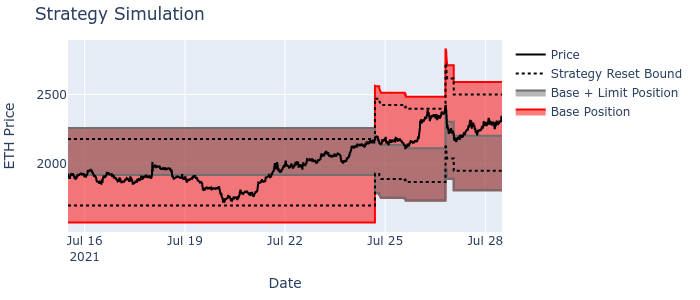

In [118]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

CHART_SIZE = 300

fig_strategy = go.Figure()
fig_strategy.add_trace(go.Scatter(
    x=data_strategy['time'], 
    y=data_strategy['base_range_lower_usd'],
    fill=None,
    mode='lines',
    showlegend = False,
    line_color='#ff0000',
    ))
fig_strategy.add_trace(go.Scatter(
    x=data_strategy['time'], 
    y=data_strategy['base_range_upper_usd'],
    name='Base Position',
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='#ff0000',))

fig_strategy.add_trace(go.Scatter(
    x=data_strategy['time'], 
    y=data_strategy['limit_range_lower_usd'],
    fill=None,
    mode='lines',
    showlegend = False,
    line_color='#6f6f6f'))

fig_strategy.add_trace(go.Scatter(
    x=data_strategy['time'], 
    y=data_strategy['limit_range_upper_usd'],
    name='Base + Limit Position',
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='#6f6f6f',))

fig_strategy.add_trace(go.Scatter(
    x=data_strategy['time'], 
    y=data_strategy['reset_range_lower_usd'],
    name='Strategy Reset Bound',
    line=dict(width=2,dash='dot',color='black')))

fig_strategy.add_trace(go.Scatter(
    x=data_strategy['time'], 
    y=data_strategy['reset_range_upper_usd'],
    showlegend = False,
    line=dict(width=2,dash='dot',color='black',)))

fig_strategy.add_trace(go.Scatter(
    x=data_strategy['time'], 
    y=data_strategy['price_1_0'],
    name='Price',
    line=dict(width=2,color='black')))

fig_strategy.update_layout(
    margin=dict(l=20, r=20, t=40, b=20),
    height= CHART_SIZE,
    title = 'Strategy Simulation',
    xaxis_title="Date",
    yaxis_title="ETH Price",
)

fig_strategy.show(renderer="png")

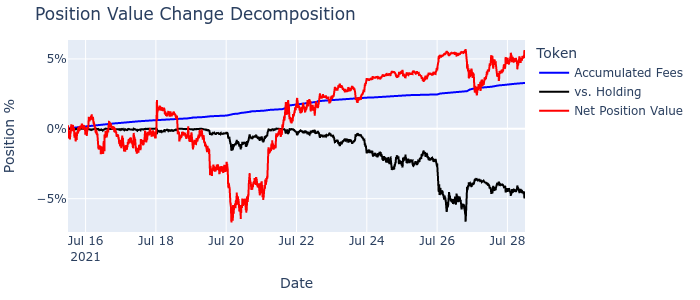

In [119]:
# 2 - Return Decomposition
fig_income = go.Figure()
fig_income.add_trace(go.Scatter(
    x=data_strategy['time'], 
    y=data_strategy['cum_fees_usd']/INITIAL_POSITION_VALUE,
    fill=None,
    mode='lines',
    line_color='blue',
    name='Accumulated Fees',
    ))

fig_income.add_trace(go.Scatter(
    x=data_strategy['time'], 
    y=data_strategy['relative_to_holding'],
    fill=None,
    mode='lines',
    line_color='black',
    name='vs. Holding',
    ))

fig_income.add_trace(go.Scatter(
    x=data_strategy['time'], 
    y=data_strategy['net_gain'],
    fill=None,
    mode='lines',
    line_color='#ff0000',
    name='Net Position Value'
    ))

fig_income.update_layout(
    margin=dict(l=20, r=20, t=40, b=20),
    height= CHART_SIZE,
    title = 'Position Value Change Decomposition',
    xaxis_title="Date",
    yaxis_title="Position %",
    legend_title='Token',
    yaxis=dict(tickformat = "%"),
)

fig_income.show(renderer="png")


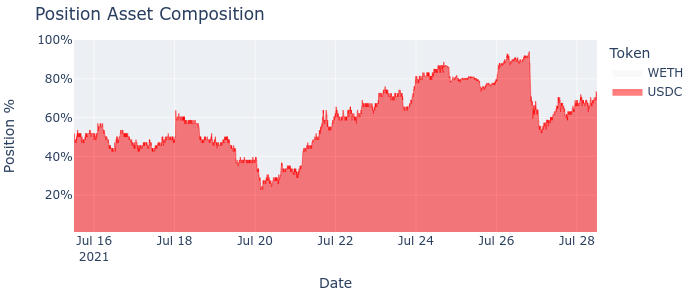

In [120]:
# 3 - Asset Composition
fig_composition = go.Figure()
fig_composition.add_trace(go.Scatter(
    x=data_strategy['time'], y=data_strategy['token_0_total'],
    mode='lines',
    name=price_data['baseCurrency'][0],
    line=dict(width=0.5, color='#ff0000'),
    stackgroup='one', # define stack group
    groupnorm='percent'
))
fig_composition.add_trace(go.Scatter(
    x=data_strategy['time'], y=data_strategy['token_1_total']*data_strategy['price_1_0'],
    mode='lines',
    name=price_data['quoteCurrency'][0],
    line=dict(width=0.5, color='#f4f4f4'),
    stackgroup='one'
))

fig_composition.update_layout(
    showlegend=True,
    xaxis_type='date',
    yaxis=dict(
        type='linear',
        range=[1, 100],
        ticksuffix='%'))

fig_composition.update_layout(
    margin=dict(l=20, r=20, t=40, b=20),
    height= CHART_SIZE,
    title = 'Position Asset Composition',
    xaxis_title="Date",
    yaxis_title="Position %",
    legend_title='Token'
)

fig_composition.show(renderer="png")

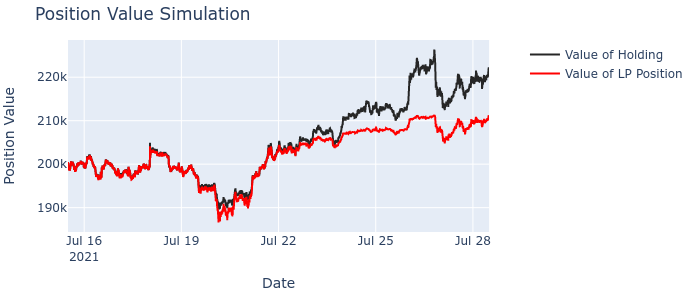

In [121]:
# 4 - Performance Comparison
from plotly.subplots import make_subplots
fig_performance = make_subplots(specs=[[{"secondary_y": True}]])
fig_performance.add_trace(go.Scatter(
    x=data_strategy['time'], 
    y=data_strategy['value_hold'],
    name='Value of Holding',
    fill=None,
    mode='lines',
    line_color='#262626',
    ),secondary_y=False,)

fig_performance.add_trace(go.Scatter(
    x=data_strategy['time'], 
    y=data_strategy['value_position'],
    name='Value of LP Position',
    fill=None,
    mode='lines',
    line_color='#ff0000',    
    ),secondary_y=False,)

fig_performance.update_layout(
    margin=dict(l=20, r=20, t=40, b=20),
    height= CHART_SIZE,
    title = 'Position Value Simulation',
    xaxis_title="Date",
    yaxis_title="Position Value",
)
fig_performance.show(renderer="png")

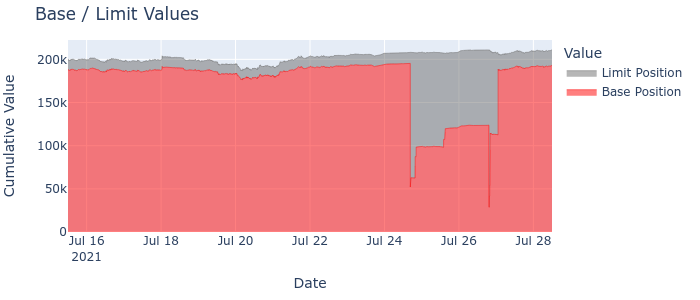

In [122]:
# 5 - Position Composition
fig_position_composition = go.Figure()
fig_position_composition.add_trace(go.Scatter(
    x=data_strategy['time'], y=data_strategy['base_position_value'],
    mode='lines',
    name='Base Position',
    line=dict(width=0.5, color='#ff0000'),
    stackgroup='one', # define stack group
#     groupnorm='percent'
))
fig_position_composition.add_trace(go.Scatter(
    x=data_strategy['time'], y=data_strategy['limit_position_value'],
    mode='lines',
    name='Limit Position',
    line=dict(width=0.5, color='#6f6f6f'),
    stackgroup='one'
))

fig_position_composition.update_layout(
    margin=dict(l=20, r=20, t=40, b=20),
    height= CHART_SIZE,
    title = 'Base / Limit Values',
    xaxis_title="Date",
    yaxis_title="Cumulative Value",
    legend_title='Value'
)

fig_position_composition.show(renderer="png")


# Dashboard

If you have Jupyter Dash installed this can be shown as a dashboard using the following lines:

In [38]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from jupyter_dash import JupyterDash
import plotly.express as px

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = JupyterDash(__name__,external_stylesheets=external_stylesheets)

# Create server variable with Flask server object for use with gunicorn
server = app.server

DATE_BEGIN          = pd.to_datetime('2021-07-01 00:00PM',utc=True)
DATE_END            = pd.to_datetime('2021-07-28 00:00PM',utc=True)

def serve_layout():
  return html.Div(
    html.Div([
        html.Link(href='https://fonts.googleapis.com/css?family=Montserrat', rel='stylesheet'),
        html.Div(
            [
                html.Img(
                    src="https://miro.medium.com/max/1400/1*8GEochGk_WlYr9gjJ5ybeQ.png",
                    style={
                        'height': '15%',
                        'width': '15%',
                        'float': 'right'
                    },
                ),
                html.H1(children='Gamma Strategies Simulator',
                       style={'color': '#ff0000',
                              'fontSize': '52px',
                              'font-family': 'Montserrat',
                              'font-weight': 'bold'}),
                html.Div(['Analyzing strategy over the period ',DATE_BEGIN.strftime("%Y-%m-%d"),' — ',DATE_END.strftime("%Y-%m-%d"),
                         html.Br(),
                         'Initial Assets: {:.2f} {} || {:.2f} {} || Value {:.2f}'.format(INITIAL_TOKEN_0,price_data['quoteCurrency'][0],INITIAL_TOKEN_1,price_data['baseCurrency'][0],INITIAL_POSITION_VALUE),

                         ],
                         style={'font-family': 'Montserrat'})
            ]),
        
        html.Div([
            html.Br(),
            html.H4('Strategy'),
        html.Div([dcc.Graph(figure=fig_strategy)])
        ]),
                        
        html.Div([
            html.H4('Strategy Performance (IL)'),
            dcc.Graph(figure=fig_income)],
                className='six columns'),
               html.Div([
            html.H4('Asset Composition'),
            dcc.Graph(figure=fig_composition)],
                className='four columns')
    ]))

app.layout = serve_layout

app.run_server(mode='jupyterlab')